# Predicting Pathogen from RNAseq data

In [1]:
from math import pow
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.pipeline import Pipeline

random_state = 0xDEADCAFE

In [2]:
patient_groups=["control", "viral", "bacterial", "fungal"]
group_id = lambda name: patient_groups.index(name)

X = pd.DataFrame.from_csv("combineSV_WTcpmtable_v2.txt", sep="\s+").T
y = [group_id("bacterial")] * 29 \
    + [group_id("viral")] * 42 \
    + [group_id("fungal")] * 10 \
    + [group_id("control")] * 61

print "Complete data set has %d samples and %d features." % (X.shape[0], X.shape[1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)
print "Training set has %d samples. Testing set has %d samples." % (len(X_train), len(X_test))

Complete data set has 142 samples and 25342 features.
Training set has 99 samples. Testing set has 43 samples.


In [3]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.linear_model import RandomizedLogisticRegression

parameters={'estimator__C': [pow(2, i) for i in xrange(-25, 4, 1)]}
svc = LinearSVC(class_weight='balanced')
rfe = RFECV(estimator=svc, step=.02, cv=2, scoring='accuracy', n_jobs=1)
clf = GridSearchCV(rfe, parameters, scoring='accuracy', n_jobs=8, cv=2, verbose=1)
clf.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (clf.best_score_, clf.best_params_))
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
params = clf.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 2 folds for each of 29 candidates, totalling 58 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  5.9min
[Parallel(n_jobs=8)]: Done  58 out of  58 | elapsed:  9.5min finished


Best: 0.484848 using {'estimator__C': 0.015625}
0.454545 (0.084520) with: {'estimator__C': 2.9802322387695312e-08}
0.454545 (0.084520) with: {'estimator__C': 5.960464477539063e-08}
0.444444 (0.074108) with: {'estimator__C': 1.1920928955078125e-07}
0.414141 (0.103506) with: {'estimator__C': 2.384185791015625e-07}
0.393939 (0.082683) with: {'estimator__C': 4.76837158203125e-07}
0.434343 (0.104119) with: {'estimator__C': 9.5367431640625e-07}
0.383838 (0.092482) with: {'estimator__C': 1.9073486328125e-06}
0.444444 (0.094319) with: {'estimator__C': 3.814697265625e-06}
0.424242 (0.073496) with: {'estimator__C': 7.62939453125e-06}
0.474747 (0.064921) with: {'estimator__C': 1.52587890625e-05}
0.464646 (0.074721) with: {'estimator__C': 3.0517578125e-05}
0.424242 (0.053284) with: {'estimator__C': 6.103515625e-05}
0.454545 (0.084520) with: {'estimator__C': 0.0001220703125}
0.404040 (0.012249) with: {'estimator__C': 0.000244140625}
0.393939 (0.062471) with: {'estimator__C': 0.00048828125}
0.363636

Optimal number of features : 8138
Recursive Feature Elimination (RFE) eliminated 17204 features


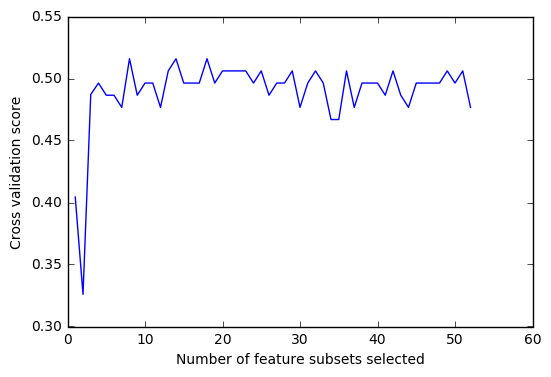

In [15]:
best_estimator = clf.best_estimator_

print("Optimal number of features : %d" % best_estimator.n_features_)
print("Recursive Feature Elimination (RFE) eliminated %d features" % (X.shape[1] - best_estimator.n_features_))

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of feature subsets selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(best_estimator.grid_scores_) + 1), best_estimator.grid_scores_)
plt.show()

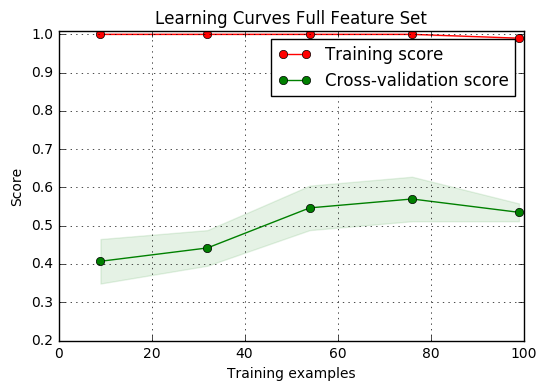

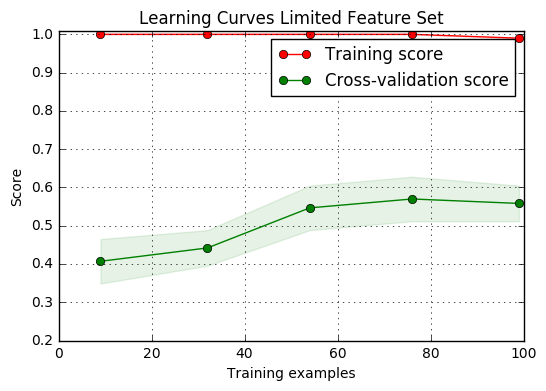

In [34]:
%matplotlib inline
from learning_curves import plot_learning_curve
import matplotlib.pyplot as plt

def create_learning_curve(title, model):
    cv = ShuffleSplit(n_splits=2, test_size=0.3, random_state=random_state)
    plot_learning_curve(model, title, X, y, (0.2, 1.01), cv=cv, n_jobs=1)
    
create_learning_curve("Learning Curves Full Feature Set", svc)
create_learning_curve("Learning Curves Limited Feature Set", best_estimator.estimator_)

plt.show()

## Make predictions based on the model

In [37]:
from classification_metrics import classification_metrics

# make predictions
predicted = best_estimator.predict(X_test)

classification_metrics(y_test, predicted, patient_groups)

Accuracy was 62.79%

             precision    recall  f1-score   support

    control       0.58      0.83      0.68        18
      viral       0.88      0.44      0.58        16
  bacterial       0.56      0.62      0.59         8
     fungal       0.00      0.00      0.00         1

avg / total       0.67      0.63      0.61        43

Confusion Matrix: cols = predictions, rows = actual

                       control          viral      bacterial         fungal
        control             15              1              2              0
          viral              8              7              1              0
      bacterial              3              0              5              0
         fungal              0              0              1              0


## Review model predictions

In [38]:
probs = np.array(best_estimator.predict(X_test))

d = {"Predicted": [patient_groups[i] for i in best_estimator.predict(X_test)],
     "Actual": [patient_groups[i] for i in y_test]}

patient_df = pd.DataFrame(d, index=X_test.index)
patient_df.sort_values(by="Actual")

,Actual,Predicted
MNC.473,bacterial,bacterial
MN_223,bacterial,bacterial
MN_208,bacterial,bacterial
MNC.557,bacterial,control
MN_363,bacterial,bacterial
MN_304,bacterial,bacterial
MNC.214,bacterial,control
MN_307,bacterial,control
MNC.611,control,control
MN_366,control,control


## Review patients the model misclassified

In [39]:
patient_df[patient_df["Predicted"] != patient_df["Actual"]]

,Actual,Predicted
MNC.557,bacterial,control
MN_284,viral,control
MN_323,fungal,bacterial
MNC.674,viral,control
MNC.534,viral,control
MNC.631,control,bacterial
MNC.392,control,viral
MN_307,bacterial,control
MN_100,viral,control
MNC.012.y,viral,control
